## POS tagging using modified Viterbi

### Data Preparation

In [103]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [104]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [105]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [106]:
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [107]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:3])

3718
196
[[('Without', 'ADP'), ('congressional', 'ADJ'), ('action', 'NOUN'), (',', '.'), ('the', 'DET'), ('Treasury', 'NOUN'), ('ca', 'VERB'), ("n't", 'ADV'), ('sell', 'VERB'), ('any', 'DET'), ('new', 'ADJ'), ('securities', 'NOUN'), ('--', '.'), ('even', 'ADJ'), ('savings', 'NOUN'), ('bonds', 'NOUN'), ('.', '.')], [('Bond', 'NOUN'), ('prices', 'NOUN'), ('were', 'VERB'), ('up', 'ADV'), ('.', '.')], [('The', 'DET'), ('radio', 'NOUN'), ('show', 'NOUN'), ('``', '.'), ('enraged', 'VERB'), ('us', 'PRON'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mrs.', 'NOUN'), ('Ward', 'NOUN'), ('.', '.')]]


In [108]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95715

In [109]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Without',
 'congressional',
 'action',
 ',',
 'the',
 'Treasury',
 'ca',
 "n't",
 'sell',
 'any']

In [110]:
# vocabulary
V = set(tokens)
print(len(V))

12104


In [111]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [112]:
print(T)

{'PRT', 'X', 'PRON', '.', 'ADJ', 'NOUN', 'CONJ', 'ADV', 'NUM', 'ADP', 'DET', 'VERB'}


### Build the vanilla Viterbi based POS tagger

In [113]:
# Create numpy array of no of pos tags by total vocabulary
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [114]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [115]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [116]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [117]:
tags_matrix

array([[1.63934426e-03, 1.34426225e-02, 1.77049171e-02, 4.36065570e-02,
        8.68852437e-02, 2.46557370e-01, 2.29508197e-03, 9.50819626e-03,
        5.63934408e-02, 2.09836066e-02, 1.00655735e-01, 4.00327861e-01],
       [1.82915211e-01, 7.52619877e-02, 5.54144159e-02, 1.65290564e-01,
        1.65131781e-02, 6.28771037e-02, 1.03207370e-02, 2.50873286e-02,
        2.85805017e-03, 1.44807875e-01, 5.55731989e-02, 2.03080341e-01],
       [1.30769229e-02, 9.30769220e-02, 7.69230770e-03, 4.03846167e-02,
        7.34615400e-02, 2.11153850e-01, 4.99999989e-03, 3.38461548e-02,
        6.92307670e-03, 2.19230764e-02, 9.99999978e-03, 4.83461529e-01],
       [2.50581698e-03, 2.66690534e-02, 6.56882077e-02, 9.39681381e-02,
        4.36728112e-02, 2.23733664e-01, 5.73653132e-02, 5.22641838e-02,
        8.19760188e-02, 9.05673876e-02, 1.72632903e-01, 8.88670161e-02],
       [1.12081757e-02, 2.10977420e-02, 4.94478329e-04, 6.49414882e-02,
        6.65897503e-02, 7.01170266e-01, 1.64826103e-02, 4.61

In [118]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [120]:
tags_df

,PRT,X,PRON,.,ADJ,NOUN,CONJ,ADV,NUM,ADP,DET,VERB
PRT,0.001639,0.013443,0.017705,0.043607,0.086885,0.246557,0.002295,0.009508,0.056393,0.020984,0.100656,0.400328
X,0.182915,0.075262,0.055414,0.165291,0.016513,0.062877,0.010321,0.025087,0.002858,0.144808,0.055573,0.203080
PRON,0.013077,0.093077,0.007692,0.040385,0.073462,0.211154,0.005000,0.033846,0.006923,0.021923,0.010000,0.483462
.,0.002506,0.026669,0.065688,0.093968,0.043673,0.223734,0.057365,0.052264,0.081976,0.090567,0.172633,0.088867
ADJ,0.011208,0.021098,0.000494,0.064941,0.066590,0.701170,0.016483,0.004615,0.019944,0.076314,0.004945,0.012197
NOUN,0.043790,0.028975,0.004623,0.239917,0.012121,0.265143,0.042589,0.017108,0.009573,0.175815,0.013177,0.147168
CONJ,0.004666,0.008399,0.057863,0.035464,0.117126,0.352310,0.000467,0.053196,0.041997,0.054130,0.118992,0.155390
ADV,0.013884,0.021818,0.014876,0.135868,0.130909,0.032397,0.007273,0.080000,0.031405,0.119008,0.071074,0.341488
NUM,0.027340,0.214562,0.001486,0.117088,0.033878,0.347994,0.012184,0.003269,0.187221,0.035067,0.002675,0.017236
ADP,0.001498,0.034782,0.069563,0.040775,0.106378,0.319777,0.000963,0.013699,0.061323,0.016481,0.325985,0.008776


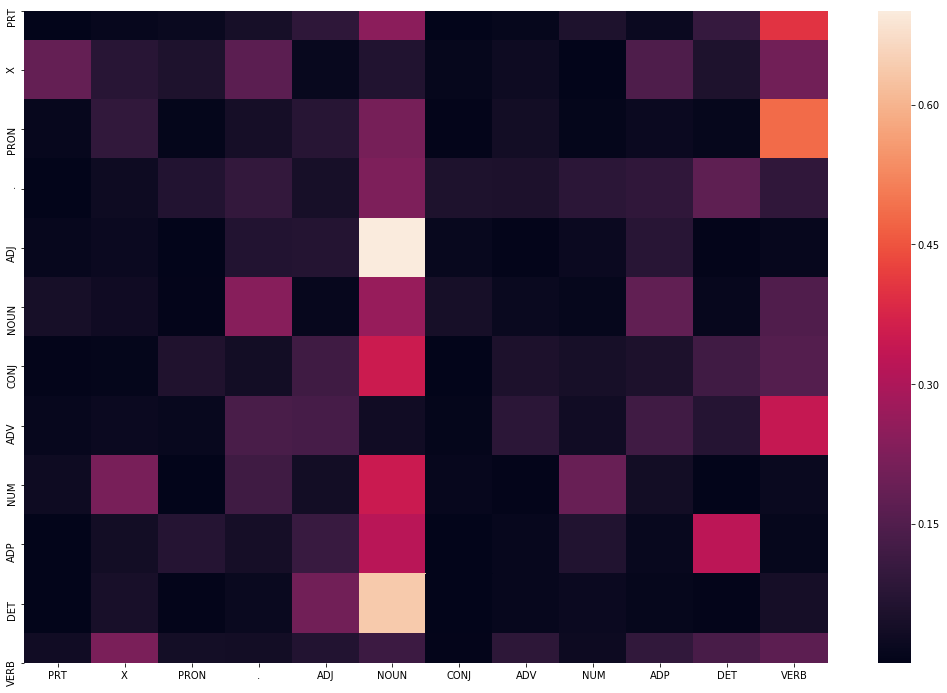

In [121]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

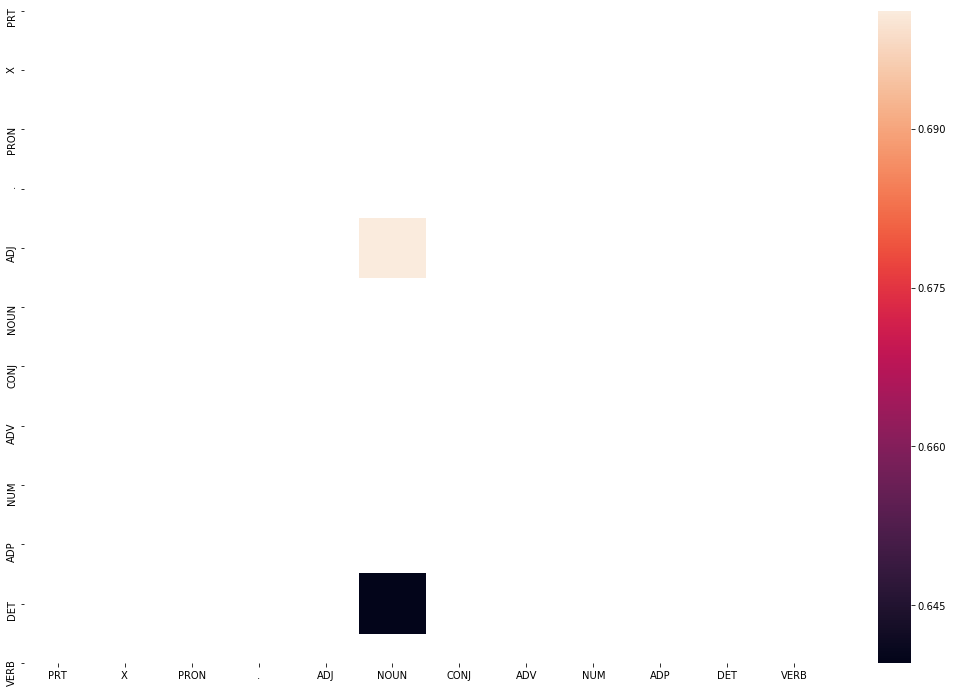

In [122]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [123]:
#Get the total length of tagged words in training corpus
len(train_tagged_words)

95715

In [124]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [125]:

# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset


# list of tagged words in test set
test_run_base = [tup for sent in test_set for tup in sent]

# list of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [126]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [127]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  3883.713440179825
[('``', '.'), ('The', 'DET'), ('company', 'NOUN'), ('does', 'VERB'), ('not', 'ADV'), ('feel', 'VERB'), ('that', 'ADP'), ('it', 'PRON'), ('or', 'CONJ'), ('any', 'DET'), ('of', 'ADP'), ('the', 'DET'), ('individuals', 'NOUN'), ('violated', 'VERB'), ('any', 'DET'), ('criminal', 'ADJ'), ('statute', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('company', 'NOUN'), ('expects', 'VERB'), ('full', 'ADJ'), ('vindication', 'NOUN'), ('in', 'ADP'), ('court', 'NOUN'), ('.', '.'), ("''", '.'), ('In', 'ADP'), ('Singapore', 'NOUN'), (',', '.'), ('a', 'DET'), ('new', 'ADJ'), ('law', 'NOUN'), ('requires', 'VERB'), ('smokers', 'NOUN'), ('to', 'PRT'), ('put', 'VERB'), ('out', 'PRT'), ('their', 'PRON'), ('cigarettes', 'NOUN'), ('before', 'ADP'), ('*-1', 'X'), ('entering', 'VERB'), ('restaurants', 'NOUN'), (',', '.'), ('department', 'NOUN'), ('stores', 'NOUN'), ('and', 'CONJ'), ('sports', 'NOUN'), ('centers', 'VERB'), ('or', 'CONJ'), ('face', 'VERB'), ('a', 'DET'), ('$',

In [128]:
# Get accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9113082039911308


In [129]:
#Read the text file
import codecs
lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Solve the problem of unknown words

In [130]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [131]:
#Strip the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [132]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('sports', 'NOUN'), (('centers', 'VERB'), ('centers', 'NOUN'))],
 [(',', '.'), (('Coche-Dury', 'PRT'), ('Coche-Dury', 'NOUN'))],
 [('1987', 'NUM'),
  (('Corton-Charlemagne', 'PRT'), ('Corton-Charlemagne', 'NOUN'))],
 [('head', 'NOUN'), (('chopped', 'PRT'), ('chopped', 'VERB'))],
 [('--', '.'), (('Obligations', 'PRT'), ('Obligations', 'NOUN'))],
 [('financial', 'ADJ'), (('instrument', 'PRT'), ('instrument', 'NOUN'))],
 [('the', 'DET'), (('agreed-upon', 'PRT'), ('agreed-upon', 'ADJ'))],
 [('and', 'CONJ'), (('Japanese', 'ADJ'), ('Japanese', 'NOUN'))],
 [('a', 'DET'), (('disproportionate', 'PRT'), ('disproportionate', 'ADJ'))],
 [('the', 'DET'), (('public', 'ADJ'), ('public', 'NOUN'))],
 [('the', 'DET'), (('table', 'PRT'), ('table', 'NOUN'))],
 [('be', 'VERB'), (('no', 'DET'), ('no', 'ADV'))],
 [('worse', 'ADJ'), (('off', 'PRT'), ('off', 'ADP'))],
 [('by', 'ADP'), (('train', 'VERB'), ('train', 'NOUN'))],
 [('the', 'DET'), (('port', 'PRT'), ('port', 'NOUN'))],
 [('certain', 'ADJ'), (('sec

In [133]:
#Get the predictions on the test sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Android', 'PRT'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRT'),
 ('.', '.'),
 ('Android', 'PRT'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('on', 'ADP'),
 ('smartphones', 'PRT'),
 ('since', 'ADP'),
 ('2011', 'PRT'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRT'),
 ('.', '.'),
 ('Google', 'PRT'),
 ('and', 'CONJ'),
 ('Twitter', 'PRT'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRT'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'PRT'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRT'),
 ("'s", 'VERB'),
 ('firehose', 'PRT'),
 ('.', '.'),
 ('Twitter', 'PRT'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRT'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NO

In [134]:
#Get the tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [135]:
#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['Google',
 'personality',
 'online',
 '2011',
 'domineering',
 'interact',
 'Twitter',
 'tweets',
 'Android',
 'messages',
 'trips',
 'smartphones',
 'worldwide',
 '21st',
 '2015',
 'OS',
 'NASA',
 'tournament',
 'FIFA',
 'ICESAT-2',
 'contested',
 'Cup',
 'firehose',
 'invited',
 'Satellite',
 'arriving',
 '2018',
 '2013']

In [136]:
#Get the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'PRT'),
 ('Google', 'PRT'),
 ('Android', 'PRT'),
 ('OS', 'PRT'),
 ('worldwide', 'PRT'),
 ('smartphones', 'PRT'),
 ('2011', 'PRT'),
 ('2013', 'PRT'),
 ('Google', 'PRT'),
 ('Twitter', 'PRT'),
 ('2015', 'PRT'),
 ('Google', 'PRT'),
 ('Twitter', 'PRT'),
 ('firehose', 'PRT'),
 ('Twitter', 'PRT'),
 ('online', 'PRT'),
 ('interact', 'PRT'),
 ('messages', 'PRT'),
 ('tweets', 'PRT'),
 ('domineering', 'PRT'),
 ('personality', 'PRT'),
 ('2018', 'PRT'),
 ('FIFA', 'PRT'),
 ('Cup', 'PRT'),
 ('21st', 'PRT'),
 ('FIFA', 'PRT'),
 ('Cup', 'PRT'),
 ('tournament', 'PRT'),
 ('contested', 'PRT'),
 ('Cup', 'PRT'),
 ('trips', 'PRT'),
 ('arriving', 'PRT'),
 ('NASA', 'PRT'),
 ('invited', 'PRT'),
 ('ICESAT-2', 'PRT'),
 ('Satellite', 'PRT')]

In [137]:
#Let us see the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'ADP': 9344,
         'ADJ': 6067,
         'NOUN': 27472,
         '.': 11174,
         'DET': 8300,
         'VERB': 12877,
         'ADV': 3025,
         'PRON': 2600,
         'X': 6298,
         'NUM': 3365,
         'CONJ': 2143,
         'PRT': 3050})

In [138]:
tag_counts.most_common(5)

[('NOUN', 27472), ('VERB', 12877), ('.', 11174), ('ADP', 9344), ('DET', 8300)]

In [139]:
#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'VERB': 28,
         'PRT': 313,
         'ADJ': 23,
         'DET': 8,
         'NOUN': 29,
         'ADP': 19,
         'ADV': 18,
         'PRON': 1,
         'NUM': 1})

In [140]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [141]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',accuracy*100)

Time taken in seconds:  4154.5674912929535
Modified Viterbi_1 Accuracy:  94.25519048578916


In [142]:
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [143]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in T:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('PRT', 0.03186543384004597),
 ('X', 0.06579950895888836),
 ('PRON', 0.027163976388235908),
 ('.', 0.11674241237005693),
 ('ADJ', 0.06338609413362586),
 ('NOUN', 0.2870187535913911),
 ('CONJ', 0.022389385153842135),
 ('ADV', 0.031604241759389855),
 ('NUM', 0.03515645405631301),
 ('ADP', 0.09762315206602935),
 ('DET', 0.08671577077783002),
 ('VERB', 0.13453481690435146)]

In [144]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',accuracy*100)

Time taken in seconds:  3913.4134097099304
Modified Viterbi_1 Accuracy:  94.79943559766177


In [145]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('centers', 'VERB'), ('centers', 'NOUN')),
 (('chopped', 'NOUN'), ('chopped', 'VERB')),
 (('agreed-upon', 'NOUN'), ('agreed-upon', 'ADJ')),
 (('Japanese', 'ADJ'), ('Japanese', 'NOUN')),
 (('disproportionate', 'NOUN'), ('disproportionate', 'ADJ')),
 (('public', 'ADJ'), ('public', 'NOUN')),
 (('no', 'DET'), ('no', 'ADV')),
 (('off', 'PRT'), ('off', 'ADP')),
 (('train', 'VERB'), ('train', 'NOUN')),
 (('East', 'NOUN'), ('East', 'ADJ')),
 (('41.60', 'NOUN'), ('41.60', 'NUM')),
 (('eyeing', 'NOUN'), ('eyeing', 'VERB')),
 (('forthcoming', 'NOUN'), ('forthcoming', 'ADJ')),
 (('10-year', 'ADJ'), ('10-year', 'NUM')),
 (('yen-denominated', 'NOUN'), ('yen-denominated', 'ADJ')),
 (('about', 'ADP'), ('about', 'ADV')),
 (('redeeming', 'NOUN'), ('redeeming', 'VERB')),
 (('double', 'ADJ'), ('double', 'VERB')),
 (('more', 'ADV'), ('more', 'ADJ')),
 (('biannual', 'VERB'), ('biannual', 'ADJ')),
 (('jet', 'NOUN'), ('jet', 'VERB')),
 (('sunny', 'NOUN'), ('sunny', 'ADJ')),
 (('Hot', 'ADJ'), ('Hot', 'NOUN')

In [146]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [147]:

# modified Viterbi
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [148]:

# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  6036.256082773209


In [149]:

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',accuracy*100)

Modified Viterbi Algorithm Accuracy:  95.64603910501916


In [150]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('centers', 'VERB'), ('centers', 'NOUN')),
 (('agreed-upon', 'NOUN'), ('agreed-upon', 'ADJ')),
 (('Japanese', 'ADJ'), ('Japanese', 'NOUN')),
 (('disproportionate', 'NOUN'), ('disproportionate', 'ADJ')),
 (('public', 'ADJ'), ('public', 'NOUN')),
 (('no', 'DET'), ('no', 'ADV')),
 (('off', 'PRT'), ('off', 'ADP')),
 (('train', 'VERB'), ('train', 'NOUN')),
 (('East', 'NOUN'), ('East', 'ADJ')),
 (('Colleges', 'VERB'), ('Colleges', 'NOUN')),
 (('forthcoming', 'VERB'), ('forthcoming', 'ADJ')),
 (('10-year', 'ADJ'), ('10-year', 'NUM')),
 (('yen-denominated', 'VERB'), ('yen-denominated', 'ADJ')),
 (('about', 'ADP'), ('about', 'ADV')),
 (('double', 'ADJ'), ('double', 'VERB')),
 (('more', 'ADV'), ('more', 'ADJ')),
 (('downgrading', 'VERB'), ('downgrading', 'NOUN')),
 (('biannual', 'VERB'), ('biannual', 'ADJ')),
 (('jet', 'NOUN'), ('jet', 'VERB')),
 (('sunny', 'NOUN'), ('sunny', 'ADJ')),
 (('confines', 'VERB'), ('confines', 'NOUN')),
 (('Hot', 'ADJ'), ('Hot', 'NOUN')),
 (('Countries', 'VERB'), ('

#### Evaluating tagging accuracy

In [151]:
#Get the predictions on the test sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi_1(word_tokenize(line)))
sample_pred_list

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

In [152]:
#Get the predictions on the test sentences
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi_2(word_tokenize(line)))
sample_pred_list

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [153]:
# vanilla viterbi gave us accuracy of 91.13%

In [154]:
#Viterbi_1 in which we used weighted trasnition probabailties gave us 94.79%

In [155]:
#Viterbi_2 in which we used grammar gave us accuracy of 95.64%

In [156]:
# words like Android ,Google were correctly tagged by viterbi_2

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [157]:
# "sports" was POS taggged as NOUN
# "Coche-Dury" was POS taggged as PRT
# "instrument" was POS taggged as PRT
# "disproportionate" was POS taggged as ADJ
# "in" was POS taggged as ADP

# all the above cases were incorrectly tagged by POS and got corrected by changes in Viterbi_1 and Viterbi_2